In [1]:
import copy
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
from os import listdir as ld
from os.path import join as pj
import numpy as np
import pandas as pd
from scipy import ndimage
import h5py
from scipy import sparse
from tqdm import tqdm

from IO.loader import parse_annotations, file_id
from evaluation.classification.statistics import compute_anno_stats, compute_average_size, compute_size_correction
from evaluation.classification.visualize import plot_size_of_anno, plot_size_by_class_of_anno
from utils.crop import *
from utils.annotate import *
from IO.build_ds import build_classification_ds

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Load data

In [2]:
root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
anno_folders = ["annotations_20200806"]
annos = []
for anno_folder in anno_folders:
    annos_name = ld(pj(root, anno_folder))
    if ".ipynb_checkpoints" in annos_name:
        annos_name.remove(".ipynb_checkpoints")
    annos.extend([pj(root, anno_folder, x) for x in annos_name])
imgs = ld(pj(root, "refined_images"))
if ".ipynb_checkpoints" in imgs:
    imgs.remove(".ipynb_checkpoints")
imgs = [pj(root, "refined_images", x) for x in imgs]

In [3]:
images = {file_id(im):np.array(Image.open(im)) for im in imgs}
annotations = {idx: list(filter(lambda x:idx in x, annos)) for idx in images}
annotations = {k:v for  k,v in annotations.items() if len(v)>0}

anno = {}
for k,v in annotations.items():
    anno[k]=[]
    for x in filter(lambda x:x.endswith(".xml"), v):
        anno[k].extend(parse_annotations(x))

# Visualize annotations

In [2]:
def concat_unknown_lbl(H, W, C):
    # get filters
    Unknown_remove_filter = C == "Unknown"
    unknown_remove_filter = C == "unknown"
    remove_filter = Unknown_remove_filter | unknown_remove_filter
    save_filter = ~(remove_filter)
    # adopt filters
    filtered_save_H = H[save_filter]
    filtered_save_W = W[save_filter]
    filtered_save_C = C[save_filter]
    filtered_save_H = np.append(filtered_save_H, H[remove_filter])
    filtered_save_W = np.append(filtered_save_W, W[remove_filter])
    filtered_save_C = np.append(filtered_save_C, np.asarray(["Unknown" for i in range(len(C[remove_filter]))]))
    return filtered_save_H, filtered_save_W, filtered_save_C

In [5]:
H,W,C,center,idx = compute_anno_stats(anno)

In [6]:
H, W, C = concat_unknown_lbl(H, W, C)

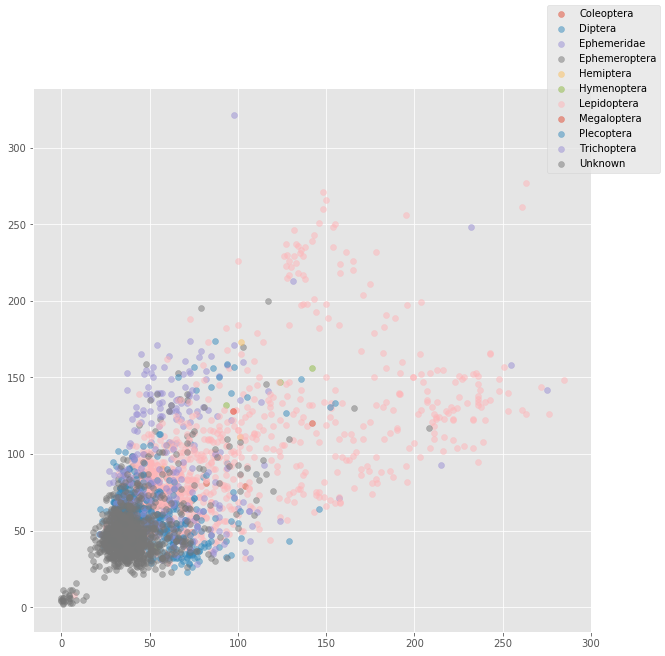

In [7]:
plot_size_by_class_of_anno(H,W,C)

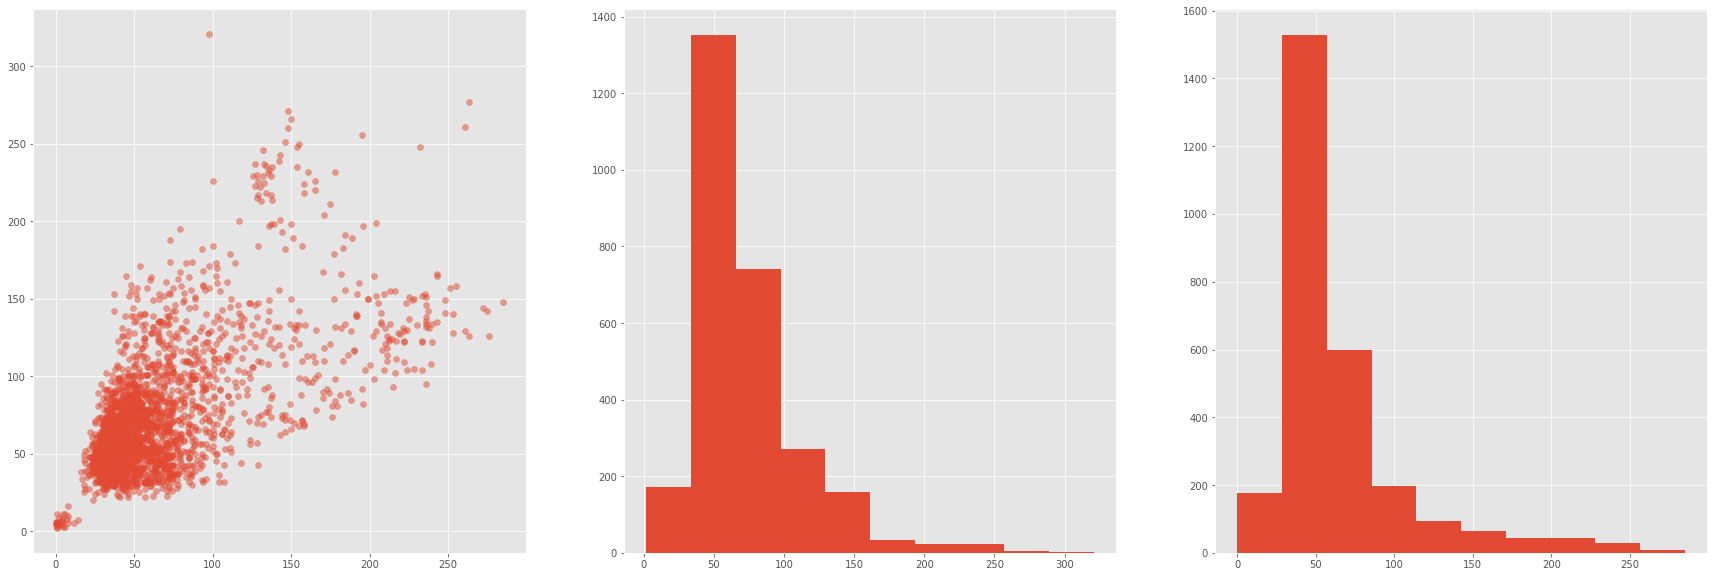

In [8]:
plot_size_of_anno(W,H)

# Analyse Dataset

In [3]:
def calculate_class_stat(H, W, C):
    mean_size = []
    labels, counts = np.unique(C, return_counts=True)
    for label in labels:
        label_filter = C == label
        filtered_H = H[label_filter]
        filtered_W = W[label_filter]
        size = filtered_H * filtered_W
        mean_size.append(size.mean())
    return labels, counts, np.asarray(mean_size)

In [4]:
def remove_unused_label(labels, counts, mean_size, unused_labels=[]):
    for unused_label in unused_labels:
        unused_filter = labels != unused_label
        labels = labels[unused_filter]
        counts = counts[unused_filter]
        mean_size = mean_size[unused_filter]
    return labels, counts, mean_size

In [5]:
def get_relative_mean_size(mean_size):
    min_size = mean_size.min()
    relative_mean_size = mean_size / min_size
    return relative_mean_size

In [12]:
unused_labels = ["]"]
labels, counts, mean_size = calculate_class_stat(H, W, C)
labels, counts, mean_size = remove_unused_label(labels, counts, mean_size, unused_labels)
relative_mean_size = get_relative_mean_size(mean_size)
df = pd.DataFrame({"label": labels, "count": counts, "mSize": mean_size, "relative_mSize": relative_mean_size})
df

,label,count,mSize,relative_mSize
0,Coleoptera,12,3725.666667,1.827180
1,Diptera,86,2851.023256,1.398228
2,Ephemeridae,92,8805.956522,4.318708
3,Ephemeroptera,93,4198.559140,2.059101
4,Hemiptera,12,5233.500000,2.566667
5,Hymenoptera,7,9824.571429,4.818268
6,Lepidoptera,944,10429.478814,5.114933
7,Megaloptera,2,14728.000000,7.223058
8,Plecoptera,359,3310.740947,1.623688
9,Trichoptera,157,5137.127389,2.519403


# Visualize Dataset

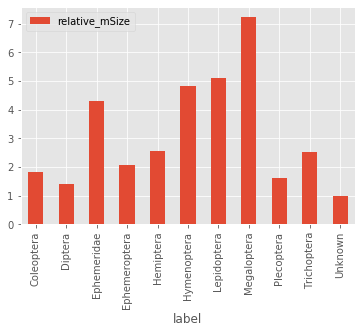

In [13]:
df.plot(kind="bar", x="label", y="relative_mSize")

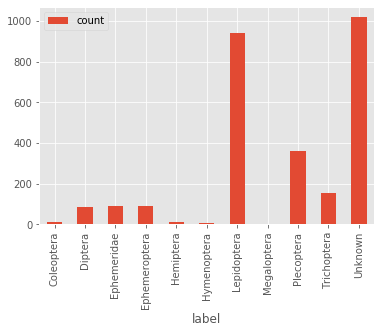

In [14]:
df.plot(kind="bar", x="label", y="count")

In [15]:
size_sorted_df = df.sort_values("relative_mSize")
size_sorted_df

,label,count,mSize,relative_mSize
10,Unknown,1019,2039.025515,1.000000
1,Diptera,86,2851.023256,1.398228
8,Plecoptera,359,3310.740947,1.623688
0,Coleoptera,12,3725.666667,1.827180
3,Ephemeroptera,93,4198.559140,2.059101
9,Trichoptera,157,5137.127389,2.519403
4,Hemiptera,12,5233.500000,2.566667
2,Ephemeridae,92,8805.956522,4.318708
5,Hymenoptera,7,9824.571429,4.818268
6,Lepidoptera,944,10429.478814,5.114933


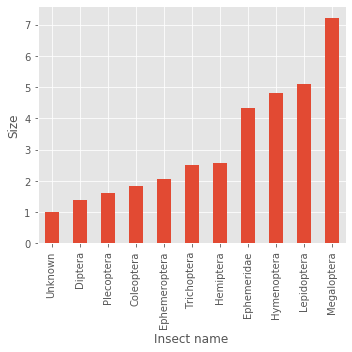

In [16]:
plt.rcParams['figure.figsize'] = (5,5)
size_sorted_df.plot(kind="bar", x="label", y="relative_mSize", legend=False)
plt.xlabel("Insect name")
plt.ylabel("Size")
plt.tight_layout()
if os.path.exists(pj(os.getcwd(), "result/classification/visualize_annotation_20200806")) is False:
    os.makedirs(pj(os.getcwd(), "result/classification/visualize_annotation_20200806"))
plt.savefig(pj(os.getcwd(), "result/classification/visualize_annotation_20200806", "average_size.png"))

In [17]:
count_sorted_df = df.sort_values("count")
count_sorted_df

,label,count,mSize,relative_mSize
7,Megaloptera,2,14728.000000,7.223058
5,Hymenoptera,7,9824.571429,4.818268
0,Coleoptera,12,3725.666667,1.827180
4,Hemiptera,12,5233.500000,2.566667
1,Diptera,86,2851.023256,1.398228
2,Ephemeridae,92,8805.956522,4.318708
3,Ephemeroptera,93,4198.559140,2.059101
9,Trichoptera,157,5137.127389,2.519403
8,Plecoptera,359,3310.740947,1.623688
6,Lepidoptera,944,10429.478814,5.114933


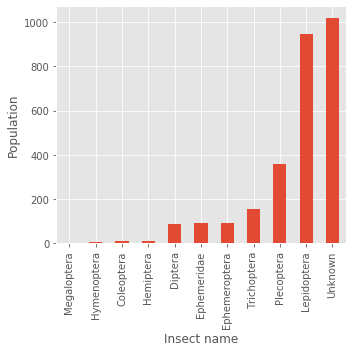

In [18]:
plt.rcParams['figure.figsize'] = (5,5)
count_sorted_df.plot(kind="bar", x="label", y="count", legend=False)
plt.xlabel("Insect name")
plt.ylabel("Population")
plt.tight_layout()
plt.savefig(pj(os.getcwd(), "result/classification/visualize_annotation_20200806", "population.png"))

# Visualize sum Dataset

In [6]:
def concat_medium_small_lbl(H, W, C):
    # get filters
    Unknown_remove_filter = C == "medium insect"
    unknown_remove_filter = C == "small insect"
    remove_filter = Unknown_remove_filter | unknown_remove_filter
    save_filter = ~(remove_filter)
    # adopt filters
    filtered_save_H = H[save_filter]
    filtered_save_W = W[save_filter]
    filtered_save_C = C[save_filter]
    filtered_save_H = np.append(filtered_save_H, H[remove_filter])
    filtered_save_W = np.append(filtered_save_W, W[remove_filter])
    filtered_save_C = np.append(filtered_save_C, np.asarray(["Unknown" for i in range(len(C[remove_filter]))]))
    return filtered_save_H, filtered_save_W, filtered_save_C

### 20191106

In [7]:
root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
anno_folders = ["annotations_0","annotations_2","annotations_3","annotations_4"]
annos = []
for anno_folder in anno_folders:
    annos_name = ld(pj(root, anno_folder))
    if ".ipynb_checkpoints" in annos_name:
        annos_name.remove(".ipynb_checkpoints")
    annos.extend([pj(root, anno_folder, x) for x in annos_name])
imgs  = ld(pj(root, "refined_images"))
if ".ipynb_checkpoints" in imgs:
    imgs.remove(".ipynb_checkpoints")
imgs  = [pj(root, "refined_images", x) for x in imgs]

In [8]:
images = {file_id(im):np.array(Image.open(im)) for im in imgs}
annotations = {idx: list(filter(lambda x:idx in x, annos)) for idx in images}
annotations = {k:v for  k,v in annotations.items() if len(v)>0}

anno = {}
for k,v in annotations.items():
    anno[k]=[]
    for x in filter(lambda x:x.endswith(".xml"), v):
        anno[k].extend(parse_annotations(x))

In [9]:
annos_20191106 = annos
anno_20191106 = anno
imgs_20191106 = imgs
images_20191106 = images

In [10]:
H,W,C,center,idx = compute_anno_stats(anno_20191106)

In [11]:
H,W,C = concat_medium_small_lbl(H, W, C)

In [12]:
unused_labels = ["]", "snail", "spider"]
labels, counts, mean_size = calculate_class_stat(H, W, C)
labels, counts, mean_size = remove_unused_label(labels, counts, mean_size, unused_labels)
relative_mean_size = get_relative_mean_size(mean_size)
df_20191106 = pd.DataFrame({"label": labels, "Count": counts, "mSize": mean_size, "relative_mSize": relative_mean_size})
df_20191106

,label,Count,mSize,relative_mSize
0,Coleoptera,30,2036.500000,3.809764
1,Diptera,419,6207.202864,11.612068
2,Ephemeridae,51,13069.333333,24.449335
3,Ephemeroptera,200,2803.800000,5.245183
4,Hemiptera,19,1005.526316,1.881079
5,Lepidoptera,271,9864.719557,18.454333
6,Plecoptera,134,4010.194030,7.502034
7,Trichoptera,250,3700.896000,6.923417
8,Unknown,2206,534.547597,1.000000


### 20200806

In [13]:
root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
anno_folders = ["annotations_20200806"]
annos = []
for anno_folder in anno_folders:
    annos_name = ld(pj(root, anno_folder))
    if ".ipynb_checkpoints" in annos_name:
        annos_name.remove(".ipynb_checkpoints")
    annos.extend([pj(root, anno_folder, x) for x in annos_name])
imgs = ld(pj(root, "refined_images"))
if ".ipynb_checkpoints" in imgs:
    imgs.remove(".ipynb_checkpoints")
imgs = [pj(root, "refined_images", x) for x in imgs]

In [14]:
images = {file_id(im):np.array(Image.open(im)) for im in imgs}
annotations = {idx: list(filter(lambda x:idx in x, annos)) for idx in images}
annotations = {k:v for  k,v in annotations.items() if len(v)>0}

anno = {}
for k,v in annotations.items():
    anno[k]=[]
    for x in filter(lambda x:x.endswith(".xml"), v):
        anno[k].extend(parse_annotations(x))

In [15]:
annos_20200806 = annos
anno_20200806 = anno
imgs_20200806 = imgs
images_20200806 = images

In [16]:
H,W,C,center,idx = compute_anno_stats(anno_20200806)

In [17]:
H,W,C = concat_unknown_lbl(H, W, C)

In [18]:
unused_labels = ["]"]
labels, counts, mean_size = calculate_class_stat(H, W, C)
labels, counts, mean_size = remove_unused_label(labels, counts, mean_size, unused_labels)
relative_mean_size = get_relative_mean_size(mean_size)
df_20200806 = pd.DataFrame({"label": labels, "Count": counts, "mSize": mean_size, "relative_mSize": relative_mean_size})
df_20200806

,label,Count,mSize,relative_mSize
0,Coleoptera,12,3725.666667,1.827180
1,Diptera,86,2851.023256,1.398228
2,Ephemeridae,92,8805.956522,4.318708
3,Ephemeroptera,93,4198.559140,2.059101
4,Hemiptera,12,5233.500000,2.566667
5,Hymenoptera,7,9824.571429,4.818268
6,Lepidoptera,944,10429.478814,5.114933
7,Megaloptera,2,14728.000000,7.223058
8,Plecoptera,359,3310.740947,1.623688
9,Trichoptera,157,5137.127389,2.519403


### 20191106 + 20200806

In [19]:
anno_20191106_20200806 = copy.copy(anno_20191106)
anno_20191106_20200806.update(anno_20200806)

In [20]:
H,W,C,center,idx = compute_anno_stats(anno_20191106_20200806)

In [21]:
H,W,C = concat_medium_small_lbl(H, W, C)

In [22]:
H,W,C = concat_unknown_lbl(H, W, C)

In [23]:
unused_labels = ["]", "snail", "spider"]
labels, counts, mean_size = calculate_class_stat(H, W, C)
labels, counts, mean_size = remove_unused_label(labels, counts, mean_size, unused_labels)
relative_mean_size = get_relative_mean_size(mean_size)
df_20191106_20200806 = pd.DataFrame({"label": labels, "Count": counts, "mSize": mean_size, "relative_mSize": relative_mean_size})
df_20191106_20200806

,label,Count,mSize,relative_mSize
0,Coleoptera,42,2519.119048,2.494385
1,Diptera,505,5635.655446,5.580321
2,Ephemeridae,143,10326.461538,10.225070
3,Ephemeroptera,293,3246.505119,3.214629
4,Hemiptera,31,2642.161290,2.616219
5,Hymenoptera,7,9824.571429,9.728108
6,Lepidoptera,1215,10303.511934,10.202346
7,Megaloptera,2,14728.000000,14.583392
8,Plecoptera,493,3500.855984,3.466482
9,Trichoptera,407,4254.921376,4.213144


### mSize

In [24]:
size_sorted_df_20191106_20200806 = df_20191106_20200806.sort_values("relative_mSize")
size_sorted_df_20191106_20200806

,label,Count,mSize,relative_mSize
10,Unknown,3225,1009.915969,1.000000
0,Coleoptera,42,2519.119048,2.494385
4,Hemiptera,31,2642.161290,2.616219
3,Ephemeroptera,293,3246.505119,3.214629
8,Plecoptera,493,3500.855984,3.466482
9,Trichoptera,407,4254.921376,4.213144
1,Diptera,505,5635.655446,5.580321
5,Hymenoptera,7,9824.571429,9.728108
6,Lepidoptera,1215,10303.511934,10.202346
2,Ephemeridae,143,10326.461538,10.225070


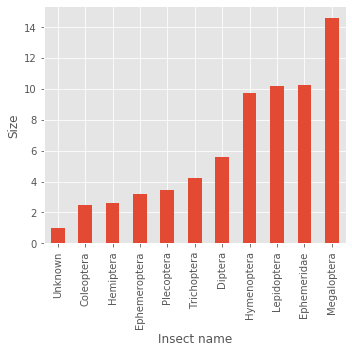

In [25]:
plt.rcParams['figure.figsize'] = (5,5)
size_sorted_df_20191106_20200806.plot(kind="bar", x="label", y="relative_mSize", legend=False)
plt.xlabel("Insect name")
plt.ylabel("Size")
plt.tight_layout()
if os.path.exists(pj(os.getcwd(), "result/classification/visualize_annotation_20200806")) is False:
    os.makedirs(pj(os.getcwd(), "result/classification/visualize_annotation_20200806"))
plt.savefig(pj(os.getcwd(), "result/classification/visualize_annotation_20200806", "average_size_sum.png"))

### population

In [26]:
df_20191106_label = np.array(list(df_20191106.label))
df_20191106_count = np.array(list(df_20191106.Count))
df_20200806_label = np.array(list(df_20200806.label))
df_20200806_count = np.array(list(df_20200806.Count))

In [27]:
df_union_label = list(set(df_20191106_label) | set(df_20200806_label))
df_union_label

['Ephemeroptera',
 'Hemiptera',
 'Ephemeridae',
 'Lepidoptera',
 'Coleoptera',
 'Plecoptera',
 'Hymenoptera',
 'Megaloptera',
 'Diptera',
 'Trichoptera',
 'Unknown']

In [28]:
df_union = pd.DataFrame()

# init df_union
df_union["label"] = df_union_label

# add df_20191106 elements
count_20191106 = np.zeros(len(df_union_label), dtype="int")
for i, label in enumerate(df_union_label):
    if label in df_20191106_label:
        count = df_20191106_count[df_20191106_label == label][0]
        count_20191106[i] = count
df_union["count_20191106"] = count_20191106

# add df_20200806 elements
count_20200806 = np.zeros(len(df_union_label), dtype="int")
for i, label in enumerate(df_union_label):
    if label in df_20200806_label:
        count = df_20200806_count[df_20200806_label == label][0]
        count_20200806[i] = count
df_union["count_20200806"] = count_20200806

df_union["count_sum"] = count_20191106 + count_20200806
count_sorted_df_union = df_union.sort_values("count_sum")

count_sorted_df_union

,label,count_20191106,count_20200806,count_sum
7,Megaloptera,0,2,2
6,Hymenoptera,0,7,7
1,Hemiptera,19,12,31
4,Coleoptera,30,12,42
2,Ephemeridae,51,92,143
0,Ephemeroptera,200,93,293
9,Trichoptera,250,157,407
5,Plecoptera,134,359,493
8,Diptera,419,86,505
3,Lepidoptera,271,944,1215


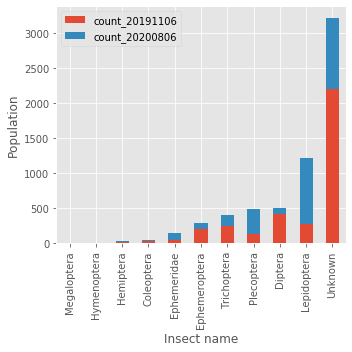

In [29]:
count_sorted_df_union.plot.bar(x="label", y=["count_20191106", "count_20200806"], stacked=True)
plt.xlabel("Insect name")
plt.ylabel("Population")
plt.tight_layout()
plt.savefig(pj(os.getcwd(), "result/classification/visualize_annotation_20200806", "population_sum.png"))